## Simulate/Import Data

In [46]:
# Choose the dataset
dataset_choice = "telemega"  # Options: simulation, telemetrum, telemega
# telemega still WIP

In [47]:
# Import libraries and functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

import flight_simulation as fsim
import helper_functions as hfunc
import rocket_classes as rktClass
import constants as con
import data_processing as dp
import plotting_functions as pf
from configs import Prometheus, Hyperion

In [48]:
if dataset_choice == "simulation":
    # Simulate flight using rocket configuration
    rocket = rktClass.Rocket(**Hyperion)

    # Simulate the flight
    (
        dataset,
        liftoff_index,
        launch_rail_cleared_index,
        burnout_index,
        apogee_index,
    ) = fsim.simulate_flight(rocket)

    A_rocket = rocket.A_rocket
    Cd_rocket_at_Re = rocket.Cd_rocket_at_Re

elif dataset_choice == "telemetrum":
    data_type = "telemetrum"
    file_path = "2022-06-24-serial-5115-flight-0001.csv"
    dataset = dp.import_and_clean_data(file_path, data_type)
    dataset = dp.calculate_aerodynamic_parameters(dataset, Prometheus)
    # Cut data to only include ascent. Last 5 points taken off so that the affects due to chute deployment at apogee aren't considered
    apogee_index = dataset["height"].idxmax() - 5
elif dataset_choice == "telemega":
    data_type = "telemega"
    file_path = "2022-06-24-serial-6583-flight-0003.csv"
    dataset = dp.import_and_clean_data(file_path, data_type)
    dataset = dp.calculate_aerodynamic_parameters(dataset, Prometheus)
    # Cut data to only include ascent. Last 5 points taken off so that the affects due to chute deployment at apogee aren't considered
    apogee_index = dataset["height"].idxmax() - 5
else:
    raise ValueError("Invalid dataset_choice selected")

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'int'

## Ascent Overview

We don't care about what happens after apogee; that's when our job finishes. We'll want to finish retracting by apogee, but at that point we're finished

In [ ]:
imperial = True

In [ ]:
if dataset_choice != "simulation":
    dataset["v_y"] = dataset["speed"]
    dataset["v_x"] = 0
    dataset["a_y"] = dataset["acceleration"]
    dataset["a_x"] = 0

    # Set first two indices
    liftoff_index = 0
    for i in range(len(dataset)):
        if dataset["height"][i] > 5.2 * np.cos(np.deg2rad(84)):
            launch_rail_cleared_index = i
            break

    from configs import Prometheus_Cd_function as Cd_rocket_at_Re
    rocket = rktClass.Rocket(**Prometheus)
    # burnout_index is set to the later of one of two events:
    #   1) accel_plus_Fg_minus_drag is less than 5 m/s^2. Would've used zero, but the data isn't perfect so it doesn't quite get there
    #   2) time of max velocity, which helps with messier data like the TeleMega's
    dataset["drag_force"] = (
        dataset["q"]
        * dataset["reynolds_num"].apply(lambda x: Cd_rocket_at_Re(x))
        * rocket.A_rocket
    )
    dataset["accel_plus_Fg_minus_drag"] = (
        dataset["a_y"] + con.F_gravity + dataset["drag_force"] / rocket.dry_mass
    )
    burnout_index = max(
        dataset["time"][
            dataset["accel_plus_Fg_minus_drag"].apply(lambda x: x < 5)
        ].idxmin(),
        dataset["speed"].idxmax(),
    )

time = dataset["time"][:apogee_index]
height = dataset["height"][:apogee_index].copy()
speed = dataset["speed"][:apogee_index].copy()
v_y = dataset["v_y"][:apogee_index].copy()
a_y = dataset["a_y"][:apogee_index].copy()
a_x = dataset["a_x"][:apogee_index].copy()
g_force = np.sqrt(a_y**2 + a_x**2) / con.F_gravity
# Set vertical velocity and acceleration to the measured totals (sensors didn't record vertical and horizontal separately)

unit = "m"
if imperial:
    height *= con.m_to_ft_conversion
    speed *= con.m_to_ft_conversion
    v_y *= con.m_to_ft_conversion
    a_y *= con.m_to_ft_conversion
    a_x *= con.m_to_ft_conversion
    unit = "ft"

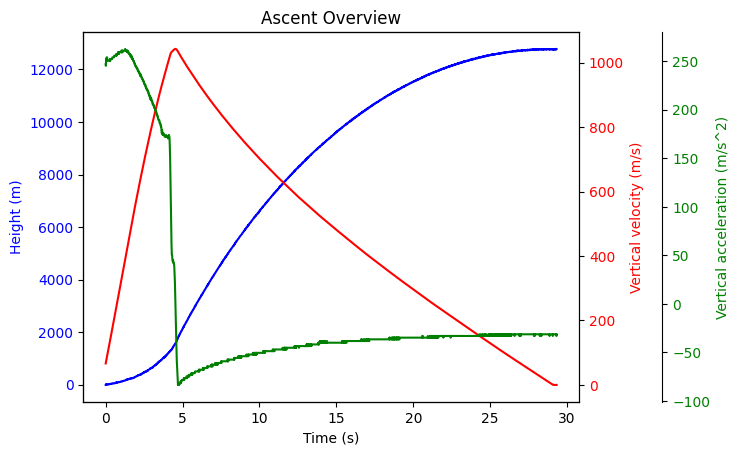

,Time (s),Height (ft),Vertical velocity (ft/s),Speed (ft/s),Vertical accel (ft/s^2),G-force (g),Re*10^7,Mach,q (kPa)
Liftoff,0.00,-0.30,66.70,66.70,246.95,7.68,0.24,0.06,0.20
Off Launch Rail,0.01,14.30,69.16,69.16,245.21,7.62,0.24,0.06,0.22
Max-g Force,1.27,159.71,391.40,391.40,262.60,8.16,1.37,0.34,6.94
Max Re,4.43,1475.16,1040.22,1040.22,41.73,1.30,3.47,0.90,46.65
Max q,4.50,1538.55,1042.59,1042.59,22.60,0.70,3.47,0.90,46.75
Max Speed,4.53,1564.60,1042.91,1042.91,3.48,0.11,3.47,0.90,46.71
Burnout,4.68,1760.60,1036.25,1036.25,-78.25,2.43,3.42,0.90,45.78
Apogee,29.32,12773.66,0.00,0.00,-31.30,0.97,-0.04,-0.01,0.00


In [ ]:
# Plot Ascent
pf.plot_ascent(time, height, speed, v_y, a_y, "m")


# Create table of parameters at key flight events
parameters_at_flight_events = pf.create_flight_event_table(
    time=time,
    height=height,
    v_y=v_y,
    speed=speed,
    a_y=a_y,
    g_force=g_force,
    reynolds_num=dataset["reynolds_num"],
    dataset=dataset,
    liftoff_index=liftoff_index,
    launch_rail_cleared_index=launch_rail_cleared_index,
    burnout_index=burnout_index,
    apogee_index=apogee_index,
    unit=unit,
)

display(parameters_at_flight_events)

# For the simulation, plot aerodynamic parameters over the ascent
if dataset_choice == "simulation":
    pf.plot_aerodynamics(
        time,
        height,
        speed,
        dataset["q"],
        dataset["reynolds_num"],
        dataset["air_density"],
        "m",
    )

## Airbrakes Simulation

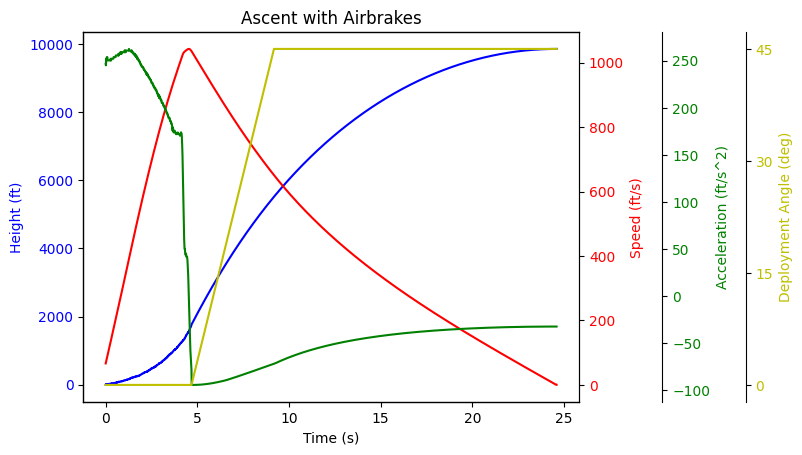

,Time (s),Height (ft),Speed (ft/s),Accel (ft/s^2),G-force (g)
Apogee with Airbrakes,24.60,9854.981909,0.315184,-32.17405,1.00
Apogee without Airbrakes,29.32,12773.660000,0.000000,-31.30000,0.97
Delta,-4.72,-2918.678091,0.315184,-0.87405,0.03
% Delta,-16.10,-22.850000,inf,2.79000,3.09


In [ ]:
# Simulate airbrakes flight

# Set flightpath until airbrake deployment as identical
airbrake_deployment = burnout_index + 1
pre_brake_flight = dataset.head(airbrake_deployment).copy()

# Set timestep based on dataset
if dataset_choice in ["telemetrum", "telemega"]:
    timestep = 0.01
else:
    timestep = 0.001

# Using the default airbrakes, the current airbrakes model in configs.py. Can set up others
ascent = fsim.simulate_airbrakes_flight(
    pre_brake_flight, rocket=rocket, timestep=timestep
)

# Analyze ascent and plot with airbrakes
pf.plot_airbrakes_ascent(ascent, unit)

# Display table of parameters at apogee
display(pf.display_apogee_parameters_table(ascent, parameters_at_flight_events, unit))